In [1]:
import pandas as pd
import muon as mu
import scanpy as sc
from muon import atac as ac
import numpy as np
import warnings
import pychromvar as pc
import sys
import os
import pickle


/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_dir = os.path.abspath('')
data_path = os.path.join(file_dir, '..', '..', 're_design', '10x_data')

h5_file_path = os.path.join(data_path, 'pbmc3k_multi.h5mu')
save_path = os.path.join(file_dir, 'generated_data')

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_h5mu(h5_file_path)
mdata

MuData object with n_obs × n_vars = 3217 × 32907
  obs:	'leiden_wnn'
  uns:	'leiden', 'leiden_wnn_colors', 'umap', 'wnn'
  obsm:	'X_umap', 'X_wnn_umap'
  obsp:	'wnn_connectivities', 'wnn_distances'
  3 modalities
    gene:	3217 x 15863
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_umap', 'leiden_euclidean', 'leiden_wnn', 'tf_leiden_umap', 'tf_leiden_euclidean'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'gene_ids_simple', 'tf'
      uns:	'hvg', 'leiden', 'leiden_umap_colors', 'leiden_umap_sizes', 'log1p', 'neighbors_euclidean', 'neighbors_umap', 'paga', 'pca', 'rank_loci_groups', 'tf_neighbors_euclidean', 'tf_neighbors_umap', 'umap'
      obsm:	'X_pca', 'X_umap', 'tf_pca'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'neighbors_euclidean_connectivities', 'neighbors_euclidean_distances', 'neighbors_umap_connectivities', 'neighbors_umap_distances', 'tf_neighbors_umap_connectivities', 'tf_neighbors_umap_distances'
    cre:	3217 x 16298
      obs:	'n_genes_by_counts', 'total_counts', 'avg_frag_length', 'leiden_umap', 'leiden_umap20', 'leiden_umap50', 'leiden_euclidean', 'leiden_wnn'
      var:	'directionality', 'orientation', 'bias_strand', 'fwd_count', 'rev_count', 'chrom', 'summit_center', 'abs_summit_diff', 'oritn_summit_diff', 'start', 'end', 'strand', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'frag_length', 'gc_bias'
      uns:	'hvg', 'leiden', 'leiden_euclidean_colors', 'leiden_umap_colors', 'leiden_umap_sizes', 'log1p', 'motif_name', 'neighbors_euclidean', 'neighbors_umap', 'paga', 'pca', 'peak_seq', 'rank_loci_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs', 'bg_peaks', 'motif_match'
      layers:	'counts'
      obsp:	'neighbors_euclidean_connectivities', 'neighbors_euclidean_distances', 'neighbors_umap_connectivities', 'neighbors_umap_distances'
    chromvar:	3217 x 746
      obs:	'leiden_wnn'
      uns:	'rank_genes_groups'

# Motif based clustering

In [7]:
mdata['cre'].var['peak_seq'] = mdata.mod['cre'].uns['peak_seq']
motif_df = mdata['cre'].var.reset_index(names='interval')
motif_df = motif_df[['interval','chrom','peak_seq']]
peak_motifs = {}
motif_df

,interval,chrom,peak_seq
0,chr1_29236_29737_-,chr1,CTCCCTCCAGCCCCTCCGGGTCCCCTACTTCGCCCCGCCAGGCCCC...
1,chr1_199774_200275_-,chr1,CCCTACTTCGCCCCGCCAGGCCCCCACGACCCTACTTCCCGCGGCC...
2,chr1_629102_629950_+,chr1,AGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTC...
3,chr1_630597_631171_+,chr1,CAAAACCCACCCCATTCCTCCCCACACTCATCGCCCTTACCACACT...
4,chr1_632356_633841_+,chr1,AACACTTTCTCGGCCTATCCGGAATGCCCCGACGTTACTCGGACTA...
...,...,...,...
16293,chrY_21028687_21029188_-,chrY,TGTGGTGAGTGTTATAGCTCATAATGTTGGCACGGACCCAAACAGT...
16294,chrY_21138232_21138733_+,chrY,ACATGACTTGCATATTTAGCATGTTAACTGCTTCATTTGGGGAGCT...
16295,chrY_21254335_21254836_+,chrY,AAATAATAAAGTGTATTATTTATCTGTTTTACATACTGTTGGTTTT...
16296,chrY_57067464_57067965_+,chrY,CGAAAGTAGAGGCAGTTCCTGTCAGATGAATTCTATTTTGTCTGTG...


In [8]:
with open(f"{save_path}/motif_call.pkl", "rb") as file:
    peak_motifs = pickle.load(file)

In [9]:
len(peak_motifs)

16298

In [10]:
all_motifs = set()
empty_idx = []
for idx, df in peak_motifs.items():
    if df.empty:
        empty_idx.append(idx)
        continue

    for motif in df.index.values.tolist():
        all_motifs.add(motif)


In [11]:
len(all_motifs)

916

In [12]:
len(empty_idx)

150

row['hit_motifs'] is a dataframe where index is motifs and one column of counts

In [13]:
# motif_df['motifs'] = motif_df['motifs'].apply(lambda x: x.index.values.tolist(), axis=1)

#motif_df.drop(index = empty_idx, inplace=True)
matrix_peak_motifs = {}
for idx, row in motif_df.iterrows():
    if idx in empty_idx:
        continue
    
    df_with_motifs = peak_motifs[idx]
    motif_counts = []
    for motif in all_motifs:
        if motif in df_with_motifs.index:
            motif_counts.append(df_with_motifs.loc[motif, 0])
        else:
            motif_counts.append(0)
        
    matrix_peak_motifs[row['interval']] = motif_counts

df_peak_motifs = pd.DataFrame.from_dict(matrix_peak_motifs)
df_peak_motifs.index = list(all_motifs)
df_peak_motifs = df_peak_motifs.T
df_peak_motifs


,UN0314.1_ZNF133,MA0526.3_USF2,MA1646.1_OSR2,UN0192.1_ZNF454,MA0883.1_Dmbx1,UN0168.1_ZNF248,MA1593.1_ZNF317,MA0733.1_EGR4,MA0693.2_VDR,MA0660.1_MEF2B,...,UN0331.1_ZNF519,MA0841.1_NFE2,MA0474.2_ERG,MA1110.1_NR1H4,MA0886.1_EMX2,UN0311.1_ZBTB2,MA0814.2_TFAP2C(var.2),UN0252.1_Dmrtb1,MA1515.1_KLF2,MA0108.2_TBP
chr1_29236_29737_-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1_199774_200275_-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1_629102_629950_+,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1_630597_631171_+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1_632356_633841_+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY_21028687_21029188_-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chrY_21138232_21138733_+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chrY_21254335_21254836_+,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
chrY_57067464_57067965_+,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_peak_motifs), index=df_peak_motifs.index, columns=df_peak_motifs.columns)

Z = linkage(df_peak_motifs, method='ward', metric='euclidean')  # method 'average', 'complete'

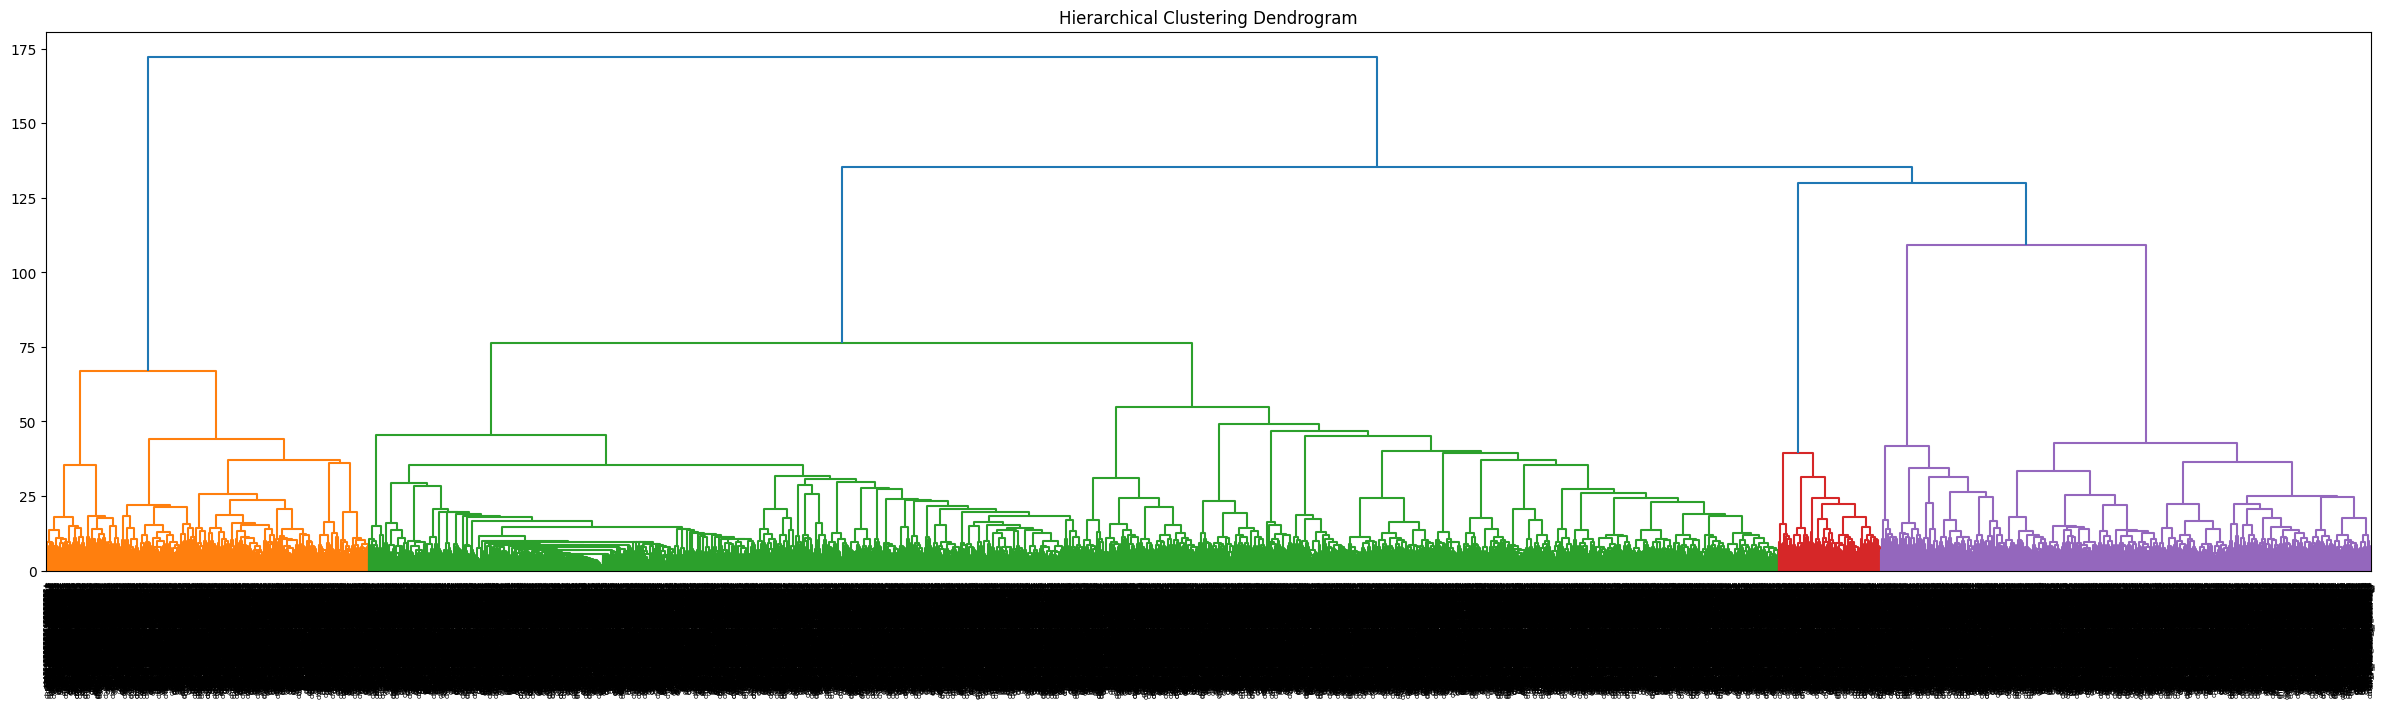

In [15]:
# Optionally plot the dendrogram

plt.figure(figsize=(30, 7))
dendrogram(Z, labels=df_peak_motifs.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [17]:
num_clusters = 3
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# Create a dictionary of loci to clusters
cre_cluster = dict(zip(df_peak_motifs.index, clusters))

pd.DataFrame.from_dict(cre_cluster, orient='index')[0].value_counts()

0
2    9792
3    4113
1    2243
Name: count, dtype: int64

In [18]:
len(cre_cluster)

16148

In [16]:
# for paint_sequence.ipynb
df_peak_motifs['cluster'] = df_peak_motifs.index.map(cre_cluster)
df_peak_motifs.to_csv("generated_data/peak_motif_count.csv")

# Final dataset based on CRE

In [19]:
mdata['cre'].var['peak_seq'] = mdata.mod['cre'].uns['peak_seq']
full_data = mdata['cre'].var.reset_index(names='interval')
# subset only required columns
full_data = full_data[['interval','chrom','start','end','summit_center','peak_seq']]

# new column cluster by mapping genes to cluster with help of gene_cluster dict
full_data['cell_type'] = full_data['interval'].map(cre_cluster)
#full_data = full_data.explode('cell_type')
full_data = full_data[full_data.cell_type.notna()]

full_data['cell_type'] = "ct"+(full_data.cell_type.astype(int)).astype(str)
full_data.reset_index(drop=True,inplace=True)
# for data constitencty with legacy code
full_data.rename(columns={'peak_seq':'sequence', 'interval':'peak'}, inplace=True)
full_data = full_data.drop(full_data[full_data.sequence.str.contains("N")].index).reset_index(drop=True)
full_data

,peak,chrom,start,end,summit_center,sequence,cell_type
0,chr1_29236_29737_-,chr1,29236,29737,29337,CTCCCTCCAGCCCCTCCGGGTCCCCTACTTCGCCCCGCCAGGCCCC...,ct2
1,chr1_199774_200275_-,chr1,199774,200275,200006,CCCTACTTCGCCCCGCCAGGCCCCCACGACCCTACTTCCCGCGGCC...,ct2
2,chr1_629102_629950_+,chr1,629102,629950,629793,AGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTC...,ct2
3,chr1_630597_631171_+,chr1,630597,631171,630948,CAAAACCCACCCCATTCCTCCCCACACTCATCGCCCTTACCACACT...,ct2
4,chr1_632356_633841_+,chr1,632356,633841,633051,AACACTTTCTCGGCCTATCCGGAATGCCCCGACGTTACTCGGACTA...,ct2
...,...,...,...,...,...,...,...
16140,chrY_21028687_21029188_-,chrY,21028687,21029188,21028788,TGTGGTGAGTGTTATAGCTCATAATGTTGGCACGGACCCAAACAGT...,ct2
16141,chrY_21138232_21138733_+,chrY,21138232,21138733,21138531,ACATGACTTGCATATTTAGCATGTTAACTGCTTCATTTGGGGAGCT...,ct2
16142,chrY_21254335_21254836_+,chrY,21254335,21254836,21254594,AAATAATAAAGTGTATTATTTATCTGTTTTACATACTGTTGGTTTT...,ct1
16143,chrY_57067464_57067965_+,chrY,57067464,57067965,57067865,CGAAAGTAGAGGCAGTTCCTGTCAGATGAATTCTATTTTGTCTGTG...,ct2


In [20]:
# check for nan values
full_data.isna().any()

peak             False
chrom            False
start            False
end              False
summit_center    False
sequence         False
cell_type        False
dtype: bool

In [21]:
print("File statistics")
print(full_data['cell_type'].value_counts())
print(full_data['chrom'].value_counts())

File statistics
cell_type
ct2    9791
ct3    4111
ct1    2243
Name: count, dtype: int64
chrom
chr1     1612
chr19    1227
chr2     1109
chr17    1041
chr11     889
chr3      846
chr12     840
chr7      839
chr6      839
chr16     733
chr5      704
chr14     615
chr9      612
chr10     596
chr4      559
chr8      526
chr15     506
chrX      480
chr20     416
chr22     389
chr13     282
chr18     225
chr21     203
chrY       39
chrM       18
Name: count, dtype: int64


In [22]:
full_data['sequence'].str.len().describe()

count    16145.000000
mean       560.506535
std        150.883586
min        501.000000
25%        501.000000
50%        501.000000
75%        501.000000
max       3654.000000
Name: sequence, dtype: float64

In [24]:
# will be test data
full_data[full_data['chrom']=='chr1']['cell_type'].value_counts()

cell_type
ct2    1044
ct3     359
ct1     209
Name: count, dtype: int64

In [25]:
file_path = os.path.join(save_path, 'tcre_seq_motif_cluster.csv')

full_data.to_csv(file_path, index=False)

# Explore

In [7]:
full_data = pd.read_csv(f'{save_path}/tcre_seq_motif_cluster.csv')
full_data

,peak,chrom,sequence,cell_type
0,chr1_29236_29737_-,chr1,CTCCCTCCAGCCCCTCCGGGTCCCCTACTTCGCCCCGCCAGGCCCC...,ct2
1,chr1_199774_200275_-,chr1,CCCTACTTCGCCCCGCCAGGCCCCCACGACCCTACTTCCCGCGGCC...,ct2
2,chr1_629102_629950_+,chr1,AGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTC...,ct2
3,chr1_630597_631171_+,chr1,CAAAACCCACCCCATTCCTCCCCACACTCATCGCCCTTACCACACT...,ct2
4,chr1_632356_633841_+,chr1,AACACTTTCTCGGCCTATCCGGAATGCCCCGACGTTACTCGGACTA...,ct2
...,...,...,...,...
16140,chrY_21028687_21029188_-,chrY,TGTGGTGAGTGTTATAGCTCATAATGTTGGCACGGACCCAAACAGT...,ct2
16141,chrY_21138232_21138733_+,chrY,ACATGACTTGCATATTTAGCATGTTAACTGCTTCATTTGGGGAGCT...,ct2
16142,chrY_21254335_21254836_+,chrY,AAATAATAAAGTGTATTATTTATCTGTTTTACATACTGTTGGTTTT...,ct1
16143,chrY_57067464_57067965_+,chrY,CGAAAGTAGAGGCAGTTCCTGTCAGATGAATTCTATTTTGTCTGTG...,ct2


In [4]:
data = full_data.drop(full_data[full_data.sequence.str.contains("N")].index).reset_index(drop=True)
data['sequence'] = data['sequence'].str[-200:]
data

,peak,chrom,sequence,cell_type
0,chr1_29236_29737_-,chr1,ACTCCGAGCTCCCGACGTGCACACGGCTCCCATGCGTTGTCTTCCG...,ct2
1,chr1_199774_200275_-,chr1,ACGGCTCCCATGCGTTGTCTTCCGAGCGTCAGGCCGCCCCTACCCG...,ct2
2,chr1_629102_629950_+,chr1,CTAGCTTTTATTCCAGTTCTAACCAAAAAAATAAACCCTCGTTCCA...,ct2
3,chr1_630597_631171_+,chr1,TCAATATGAAAATCACCTCAGAGCTGGTAAAAAGAGGCTTAACCCC...,ct2
4,chr1_632356_633841_+,chr1,TCCCTCACCAAAGCCCATAAAAATAAAAAACTATAACAAACCCTGA...,ct2
...,...,...,...,...
16140,chrY_21028687_21029188_-,chrY,GATAGATAGAAAAGTTATCCCAGTCCCCACCCAAACCAGAAGCCCA...,ct2
16141,chrY_21138232_21138733_+,chrY,GGAGTTGCACACACAGGTTTACTGATAAGAGAAGTTACTCAAACTG...,ct2
16142,chrY_21254335_21254836_+,chrY,TTTTTGTCGGGTGGAAGCATGAATACTTGTTATTCAAGTGTTCAGG...,ct1
16143,chrY_57067464_57067965_+,chrY,GAACGCAGCAGGCCTAGCCGTGTCGCCTGCTGCCATTGGAGGAGCG...,ct2


In [5]:
train_data = data[(data["chrom"]!= "chr1") & (data["chrom"] != "chr2")].reset_index(drop=True)
train_data['cell_type'].value_counts()

cell_type
ct2    8016
ct3    3513
ct1    1895
Name: count, dtype: int64

In [6]:
test_data = data[data['chrom'] == "chr1"].reset_index(drop=True)
test_data['cell_type'].value_counts()

cell_type
ct2    1044
ct3     359
ct1     209
Name: count, dtype: int64

# Explore